# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# About the data

The clasic Olivetti faces dataset contains 400 grayscale 40x40-pixel images of faces. Each image is flattened to a 1D vector size of 4096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture.

# Project Scope

In this project, we will try to make a **face recognizer**, training and tuning a classifier and using different **clustering and dimensionality reduction algorithm** to boost our results.

# Load the dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [3]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [4]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

## Split the dataset into a training set, a validation set and a test set

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

## Preprocess the data

We want to make sure that all example images have the same mean grayscale level:

In [6]:
n_samples, n_features = X_train.shape
X_train -= X_train.mean(axis=0)

In [7]:
n_samples, n_features = X_valid.shape
X_valid -= X_valid.mean(axis=0)

In [8]:
n_samples, n_features = X_test.shape
X_test -= X_test.mean(axis=0)

In [9]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


We repeat this procedure for every image to make sure the feature values of every data point are centered around zero:

In [11]:
n_samples, n_features = X_train.shape
X_train -= X_train.mean(axis=1).reshape(n_samples, -1)

In [12]:
n_samples, n_features = X_valid.shape
X_valid -= X_valid.mean(axis=1).reshape(n_samples, -1)

In [13]:
n_samples, n_features = X_test.shape
X_test -= X_test.mean(axis=1).reshape(n_samples, -1)

**We will use the PCA algorithm for dimensionality reduction with the scope of speeding things up:**

In [14]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

210

# Clustering the Olivetti Faces Dataset 

We will cluster the images using K-Means and ensure that we have a good number of clusters:

In [15]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


We'll use silhouette score to choose the best **k**

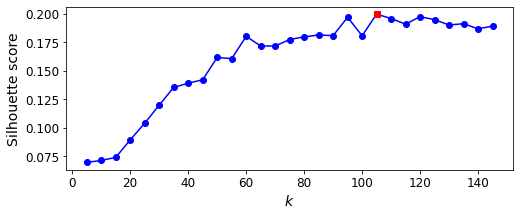

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [17]:
best_k

105

It looks like the best number of clusters is quite high, at 105. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

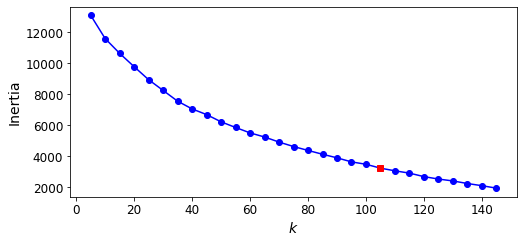

In [18]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on the inertia diagram, as there is no obvious elbow, so let's stick with k=105

In [19]:
best_model = kmeans_per_k[best_index]

Let's visualize the clusters:

Cluster 0


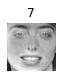

Cluster 1


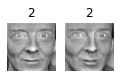

Cluster 2


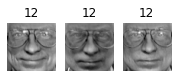

Cluster 3


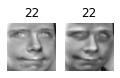

Cluster 4


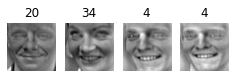

Cluster 5


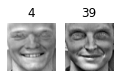

Cluster 6


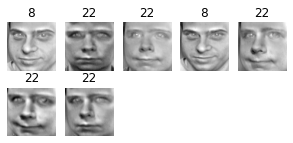

Cluster 7


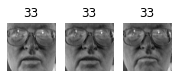

Cluster 8


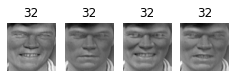

Cluster 9


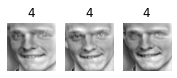

Cluster 10


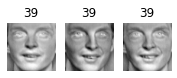

Cluster 11


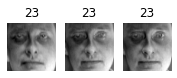

Cluster 12


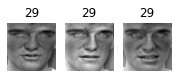

Cluster 13


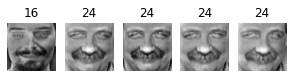

Cluster 14


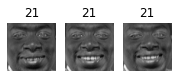

Cluster 15


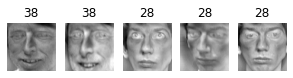

Cluster 16


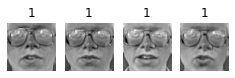

Cluster 17


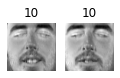

Cluster 18


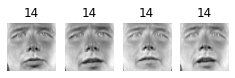

Cluster 19


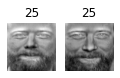

Cluster 20


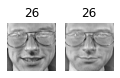

Cluster 21


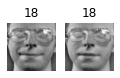

Cluster 22


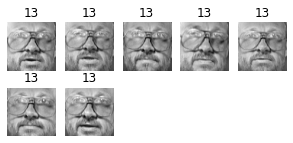

Cluster 23


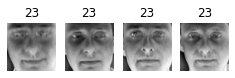

Cluster 24


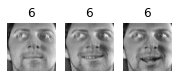

Cluster 25


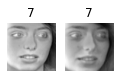

Cluster 26


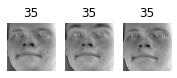

Cluster 27


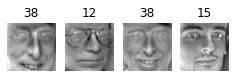

Cluster 28


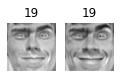

Cluster 29


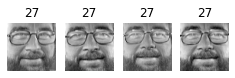

Cluster 30


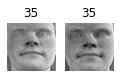

Cluster 31


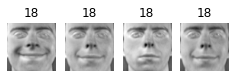

Cluster 32


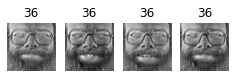

Cluster 33


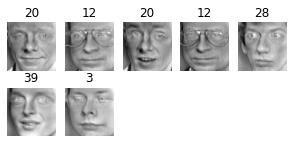

Cluster 34


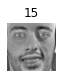

Cluster 35


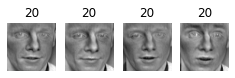

Cluster 36


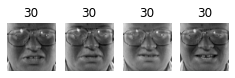

Cluster 37


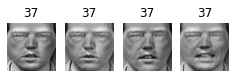

Cluster 38


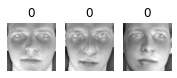

Cluster 39


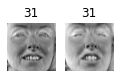

Cluster 40


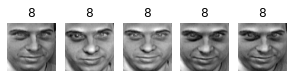

Cluster 41


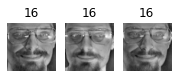

Cluster 42


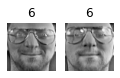

Cluster 43


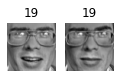

Cluster 44


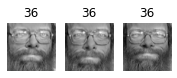

Cluster 45


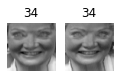

Cluster 46


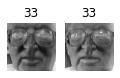

Cluster 47


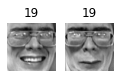

Cluster 48


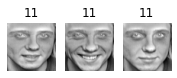

Cluster 49


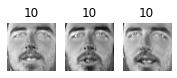

Cluster 50


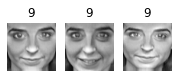

Cluster 51


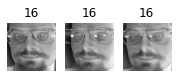

Cluster 52


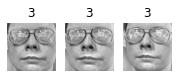

Cluster 53


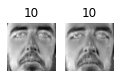

Cluster 54


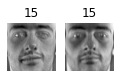

Cluster 55


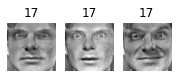

Cluster 56


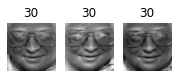

Cluster 57


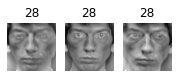

Cluster 58


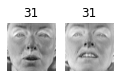

Cluster 59


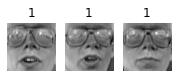

Cluster 60


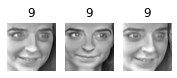

Cluster 61


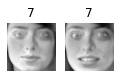

Cluster 62


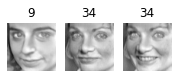

Cluster 63


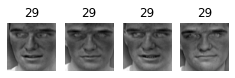

Cluster 64


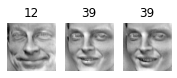

Cluster 65


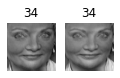

Cluster 66


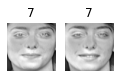

Cluster 67


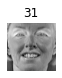

Cluster 68


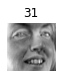

Cluster 69


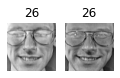

Cluster 70


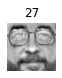

Cluster 71


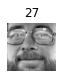

Cluster 72


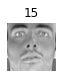

Cluster 73


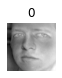

Cluster 74


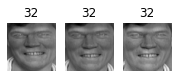

Cluster 75


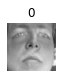

Cluster 76


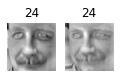

Cluster 77


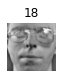

Cluster 78


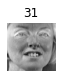

Cluster 79


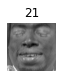

Cluster 80


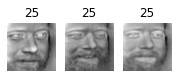

Cluster 81


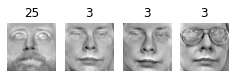

Cluster 82


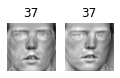

Cluster 83


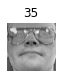

Cluster 84


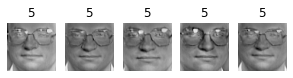

Cluster 85


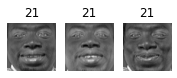

Cluster 86


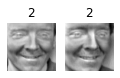

Cluster 87


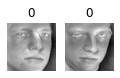

Cluster 88


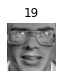

Cluster 89


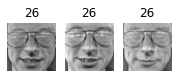

Cluster 90


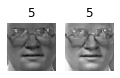

Cluster 91


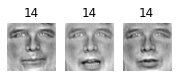

Cluster 92


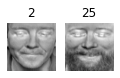

Cluster 93


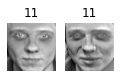

Cluster 94


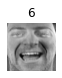

Cluster 95


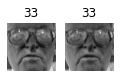

Cluster 96


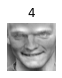

Cluster 97


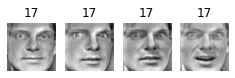

Cluster 98


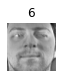

Cluster 99


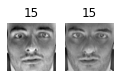

Cluster 100


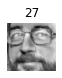

Cluster 101


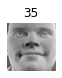

Cluster 102


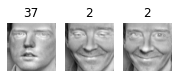

Cluster 103


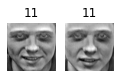

Cluster 104


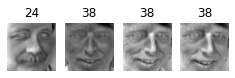

In [20]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

# Using clustering as preprocessing for Classification

Let's train a Random Forest and evaluate it on the validation set:

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.875

87.5%, good! Next, let's use K-Means as a dimensionality reduction tool to see it it imporoves the results:

In [22]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.6875

...! That's not better at all. Let's search for the number of clusters that allows the classifier to get the best performance:

In [23]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.275
10 0.425
15 0.4875
20 0.5
25 0.6125
30 0.6
35 0.5875
40 0.6375
45 0.65
50 0.675
55 0.6125
60 0.6625
65 0.65
70 0.6625
75 0.6875
80 0.6875
85 0.625
90 0.7
95 0.6625
100 0.625
105 0.6875
110 0.6375
115 0.6375
120 0.6375
125 0.675
130 0.6625
135 0.65
140 0.7
145 0.675


Oh well, even by tuning the number of clusters, we never get beyond 70% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

Let's try to append the features from the reduced set to the original features:

In [24]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [25]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.7625

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

# A Gaussian Mixture Model for the Olivetti Faces Dataset

Let's train a Gaussian mixture model on the reduced Olivetti faces dataset:

In [26]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

We will use the model to generated new faces and visualize them:

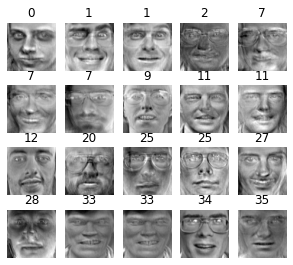

In [27]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

plot_faces(gen_faces, y_gen_faces)

Let's try to modify the images and see if the model can detect the anomalies:

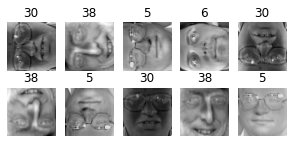

In [28]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [29]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [30]:
gm.score_samples(X_bad_faces_pca)

array([-22857324.80946902, -11761077.40799187, -10751297.77747994,
       -16592663.49884122, -22641068.09436023,  -8722484.45897888,
        -7119994.68026968,  -5432091.65561769,  -2519418.76168133,
        -1620465.88915695])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [31]:
gm.score_samples(X_train_pca[:10])

array([1228.89083605, 1162.05369379, 1149.06374009, 1236.53840813,
       1106.53537027, 1193.53181085, 1149.06374137, 1156.18462841,
       1157.18688965, 1162.05368855])

# Using Dimensionality Reduction Techniques for Anomaly Detection

Let's take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next,let's take some of the modified images you built in the previous cells, and look at their reconstruction error:

In [32]:
X_train_pca

array([[-2.5507476 , -5.3758545 ,  1.2384926 , ..., -0.12511599,
        -0.12121904, -0.17390338],
       [-3.0359771 , -1.1960213 ,  2.273289  , ..., -0.13295446,
        -0.17455105, -0.19444315],
       [ 4.2367105 , -0.635189  ,  0.7875886 , ..., -0.19541718,
         0.13724673, -0.08113034],
       ...,
       [ 2.595715  ,  1.1716381 ,  0.49167994, ...,  0.09122699,
         0.185299  ,  0.07701947],
       [ 5.715054  ,  1.3585236 ,  1.0043579 , ...,  0.10953552,
        -0.0788869 ,  0.06251482],
       [-3.5002856 ,  2.2986314 ,  1.079189  , ..., -0.1462722 ,
         0.23341042,  0.06758588]], dtype=float32)

In [33]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [34]:
reconstruction_errors(pca, X_train).mean()

0.00015034399

In [35]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0032450377

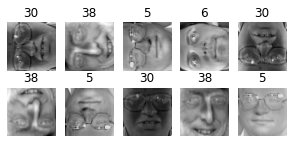

In [36]:
plot_faces(X_bad_faces, y_bad)

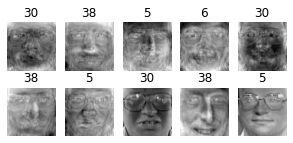

In [37]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)

# Hyperparameter Tunning: GridSearcCV

In [ ]:
'''from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 42)
param_grid =  {'n_estimators': [100,500,1000],
              'bootstrap': [True],
              'max_depth': [3,5,10,20,50,75,100,None],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [1,2,4,10],
              'min_samples_split': [2,5,10]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_rf =  clf_rf.fit(X_train_pca, y_train)'''


In [42]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [43]:
clf_performance(best_clf_rf,'Random Forest')

Random Forest
Best Score: 0.8360024403263937
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}


In [44]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 42)
param_grid =  {'n_estimators': [800,900,1000,1100,1200,1500],
              'bootstrap': [True],
              'max_depth': [10],
              'max_features': ['auto'],
              'min_samples_leaf': [10,12,15],
              'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_rf =  clf_rf.fit(X_train_pca, y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Random Forest
Best Score: 0.8467169983985358
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 900}


In [45]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 42)
param_grid =  {'n_estimators': [850,930,950,1000,1030,1050],
              'bootstrap': [True],
              'max_depth': [10],
              'max_features': ['auto'],
              'min_samples_leaf': [10],
              'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_rf =  clf_rf.fit(X_train_pca, y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest
Best Score: 0.8502249675894151
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 850}


In [46]:
best_clf_rf.score(X_valid_pca, y_valid)

0.9125

#  Evaluate the system on the test set

In [52]:
final_model = best_clf_rf

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit(X_train_pca, y_train).transform(X_train_pca)
X_test_lda=lda.transform(X_test_pca)

In [53]:
final_model.fit(X_train_lda, y_train)
y_hat = final_model.predict(X_test_lda)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy score:{:.2f}".format(accuracy_score(y_test, y_hat)))
print("Classification Results:\n{}".format(classification_report(y_test, y_hat)))

Accuracy score:0.90
Classification Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00    

C:\Users\mihae\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mihae\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mihae\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
